In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.metrics import brier_score_loss, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import lightgbm as lgb
import catboost
import optuna
from optuna.visualization import plot_param_importances

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [87]:
file = 'train.csv'

df = pd.read_csv(file)

df.head()

,uid,home_team,sz_top,sz_bot,pitch_type,release_pos_x,release_pos_y,release_pos_z,stand,p_throws,...,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z,hc_x,hc_y,launch_speed,launch_angle,is_hr
0,0,LAA,3.35,1.61,CU,-2.14,53.69,6.48,R,R,...,2110,0.73,-0.79,-0.11,3.19,138.97,86.01,94.6,47,0
1,2,LAA,3.39,1.63,CH,1.83,54.15,5.94,R,L,...,1710,1.22,0.71,0.74,1.44,111.73,159.90,69.5,-30,0
2,4,LAA,3.46,1.59,CU,-2.32,53.99,6.43,L,R,...,2154,0.73,-0.67,-0.32,2.69,112.87,148.15,93.8,66,0
3,5,LAA,3.29,1.54,SL,-2.01,53.71,6.37,R,R,...,2209,0.50,0.98,-0.20,2.14,180.78,96.91,87.5,38,0
4,6,LAA,3.47,1.65,FF,-2.16,53.61,6.29,L,R,...,2230,-0.29,1.60,0.00,2.89,134.75,101.76,100.0,-2,0


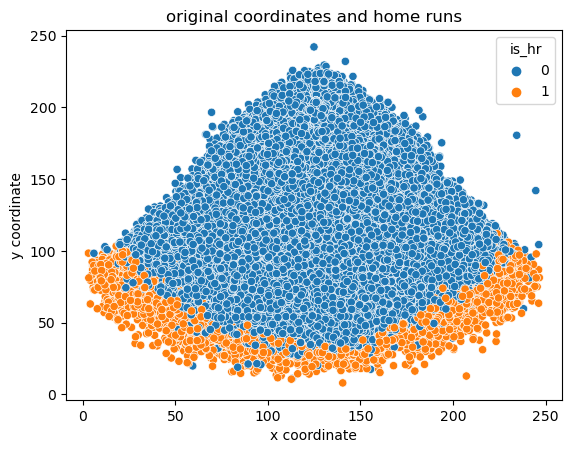

In [89]:
# since we have actual ball coordinates, let's plot them
# the plot is nice, but the coordinates not
fig, ax = plt.subplots()

sns.scatterplot(x=df['hc_x'], y=df['hc_y'], hue=df['is_hr'])
plt.title("original coordinates and home runs")

ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")

plt.show()

In [ ]:
mlbam_xy_transformation = function(data,
                                   x="hc_x", y="hc_y",
                                   column_suffix="_",
                                   scale=2.495671) {
  data[,paste0(x, column_suffix)] = scale * (data[,x] - 125)
  data[,paste0(y, column_suffix)] = scale * (199 - data[,y])
  data
}

In [90]:
# scaling and flipping x and y so they're more intelligible
df['hc_x_centered'] = 2.495671 * (df['hc_x'] - 125)
df['hc_y_flipped'] = 2.495671 * (199 - df['hc_y'])
df['implied_distance'] = np.sqrt(df['hc_x_centered'] ** 2 + df['hc_y_flipped'] ** 2)

# calculating radians from the new origin - home runs are a 
# function of distance, angle, and park for sure
df['angle_radians'] = np.arctan(df['hc_y_flipped'] / df['hc_x_centered'])

# later movement
df['lateral_movement'] = abs(df['pfx_x'])

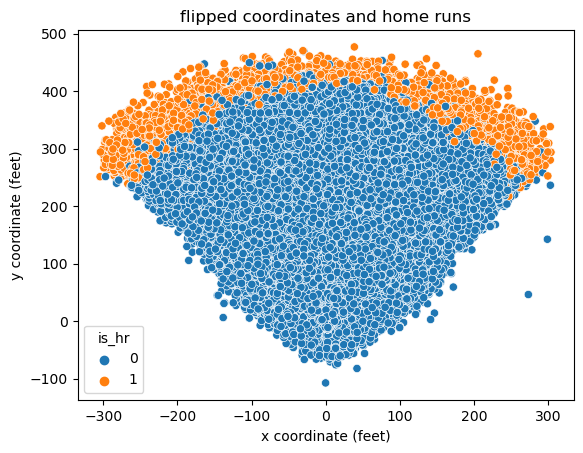

In [91]:
fig, ax = plt.subplots()

sns.scatterplot(x=df['hc_x_centered'], y=df['hc_y_flipped'], hue=df['is_hr'])
plt.title("flipped coordinates and home runs")

ax.set_xlabel("x coordinate (feet)")
ax.set_ylabel("y coordinate (feet)")

plt.show()

In [92]:
# sorting home runs by distance. clearly uid 37812 is unusual and
# out side of the distribution for the others

df[df['is_hr'] == 1][['uid', 'implied_distance']].sort_values(by='implied_distance').head(10)

,uid,implied_distance
31464,37812,3.900998
46945,56505,277.274301
32569,39151,278.233720
12201,14625,281.120209
53558,64488,290.069496
4465,5342,294.329650
70557,84930,315.352997
69339,83478,319.536972
32585,39171,320.431189
23330,27976,320.848391


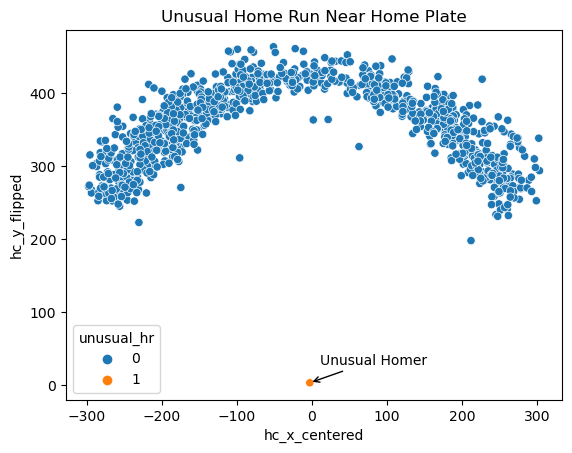

In [93]:
# plotting the unusual home run
sample_df = df[df['is_hr'] == 1].sample(1000).copy()
unusual_hr = df[df['uid'] == 37812].copy()
sample_df = pd.concat([sample_df, unusual_hr])
sample_df['unusual_hr'] = np.where(sample_df['uid'] == 37812, 1, 0)

sns.scatterplot(x='hc_x_centered', y='hc_y_flipped', data=sample_df, hue='unusual_hr')

highlight_point = sample_df[sample_df['uid'] == 37812].iloc[0]
arrow_text = "Unusual Homer"
plt.annotate(arrow_text, xy=(highlight_point['hc_x_centered'], highlight_point['hc_y_flipped']),
             xytext=(highlight_point['hc_x_centered'] + 13, highlight_point['hc_y_flipped'] +25),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.title("Unusual Home Run Near Home Plate")
plt.show()

In [94]:
# dropping the row with the unusual home run
df = df[df['uid'] != 37812].copy()

It may not be a bad idea to drop every home run under 300 (310?) feet.  

In [95]:
categorical_columns = df.select_dtypes(exclude=['float', 'int']).columns.to_list()

In [ ]:
# training an untuned catboost model on the full dataset

X = df.drop(columns=['uid', 'is_hr'])
y = df['is_hr']

model = catboost.CatBoostClassifier(cat_features=categorical_columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1944)

model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10, verbose=True)

print("the log loss on val set with untuned catboost is:", log_loss(y_val, model.predict_proba(X_val)))

In [114]:
def objective(trial):
    "an optuna objective to optimize the catboost model"
    
    model = catboost.CatBoostClassifier(
        iterations=1000,
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        verbose=False,
        cat_features=categorical_columns
    )
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10)
    
    preds = model.predict_proba(X_val)
    
    return log_loss(y_val, preds)

In [ ]:
# initializing the studies
study = optuna.create_study(study_name="catboost", direction="minimize")

study.optimize(objective, n_trials=50)

In [ ]:
# # method looks alright, training on the full dataset
# best_params = study.best_params

# final_model = catboost.CatBoostClassifier(**best_params, cat_features=categorical_columns)

# # training the untuned catboost and the optimized catboost 
# # on the full dataset
# final_model.fit(X, y)

final_model = catboost.CatBoostClassifier(iterations=228, cat_features=categorical_columns)
final_model.fit(X, y)

In [98]:
test_file = 'test.csv'

test_df = pd.read_csv(test_file)

# scaling and flipping the x, y coordinates of the test set
test_df['hc_x_centered'] = 2.495671 * (test_df['hc_x'] - 125)
test_df['hc_y_flipped'] = 2.495671 * (199 - test_df['hc_y'])
test_df['implied_distance'] = np.sqrt(test_df['hc_x_centered'] ** 2 + test_df['hc_y_flipped'] ** 2)

# same transformation as on the train set
test_df['angle_radians'] = np.arctan(test_df['hc_y_flipped'] / test_df['hc_x_centered'])

test_df['lateral_movement'] = abs(test_df['pfx_x'])

In [99]:
preds = final_model.predict(test_df.drop(columns='uid'))
test_df['is_hr'] = preds

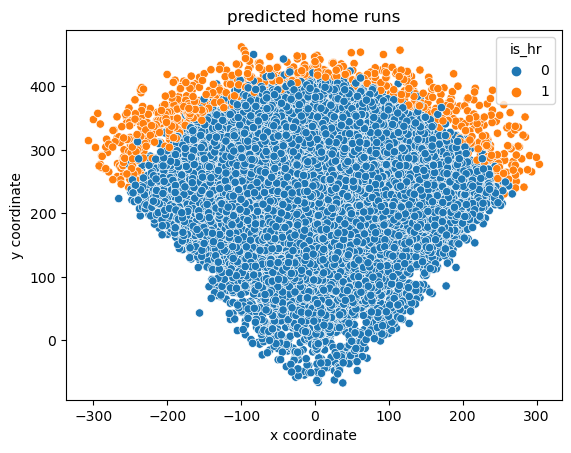

In [100]:
# plotting the predicted home run coordinates
fig, ax = plt.subplots()

sns.scatterplot(x=test_df['hc_x_centered'], y=test_df['hc_y_flipped'], hue=test_df['is_hr'])
plt.title("predicted home runs")

ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")

plt.show()

In [101]:
print("home run percentage on train set:", df['is_hr'].mean())
print("home run percentage on test set:", test_df['is_hr'].mean())

home run percentage on train set: 0.037335059810087556
home run percentage on test set: 0.03715


In [102]:
# creating submission df
submission = test_df[['uid', 'is_hr']].copy()

submission.head()

,uid,is_hr
0,100541,0
1,18420,0
2,29296,0
3,18753,0
4,72142,0


In [105]:
submission.to_csv('fifth_try.csv', index=False)